# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

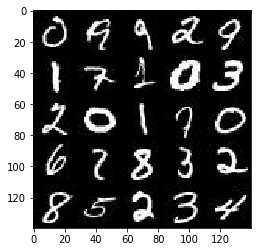

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

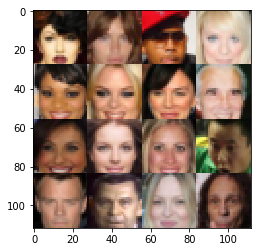

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, shape = (None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None,z_dim),name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate" )

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse = False, alpha = 0.2):

  """
  Create the discriminator network
  :param image: Tensor of input image(s)
  :param reuse: Boolean if the weights should be reused
  :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
  """ 

  with tf.variable_scope('discriminator', reuse=reuse):
    # input layer is 28x28x3
    x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
    relu1 = tf.maximum(alpha * x1, x1)
    # 14x14x128

    x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
    bn2 = tf.layers.batch_normalization(x2, training=True)
    relu2 = tf.maximum(alpha * bn2, bn2)
    # 7x7x256

    x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
    bn3 = tf.layers.batch_normalization(x3, training=True)
    relu3 = tf.maximum(alpha * bn3, bn3)
    # 4x4x512

    # Flatten it
    flat = tf.contrib.layers.flatten(relu3)  #tf.reshape(relu3, (-1, 4*4*256))
    logits = tf.layers.dense(flat, 1)
    out = tf.sigmoid(logits)
    
      
    return (out, logits) 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train    
    alpha=0.2

    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out= tf.tanh(logits)
        
        return out
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # with tf.variable_scope('discriminator'):
        
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    steps =0 
    print_every = 10
    show_every = 100
    z_size = 100
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                # TODO: Train Model
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = batch_z.reshape(batch_size, z_dim) 

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
 
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
                    
            train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
            train_loss_g = g_loss.eval({input_z: sample_z})

            if batch_size % 100 == 0:
                show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 3.0881... Generator Loss: 24.9292
Epoch 1/2... Discriminator Loss: 0.1600... Generator Loss: 11.1996
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 20.0520
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 7.6787
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 2.1704... Generator Loss: 5.6593
Epoch 1/2... Discriminator Loss: 0.4391... Generator Loss: 3.0901
Epoch 1/2... Discriminator Loss: 0.2482... Generator Loss: 2.6379
Epoch 1/2... Discriminator Loss: 0.2391... Generator Loss: 3.3618


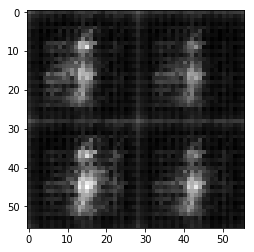

Epoch 1/2... Discriminator Loss: 0.1136... Generator Loss: 3.3588
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 1.3982
Epoch 1/2... Discriminator Loss: 0.3118... Generator Loss: 9.6139
Epoch 1/2... Discriminator Loss: 0.0148... Generator Loss: 6.5655
Epoch 1/2... Discriminator Loss: 0.2664... Generator Loss: 3.3679
Epoch 1/2... Discriminator Loss: 0.3027... Generator Loss: 2.5598
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 1.9071
Epoch 1/2... Discriminator Loss: 0.2297... Generator Loss: 4.2921
Epoch 1/2... Discriminator Loss: 0.2766... Generator Loss: 2.5212
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 0.8079


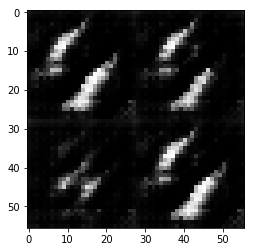

Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 5.6775
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 1.5615
Epoch 1/2... Discriminator Loss: 0.1848... Generator Loss: 3.6435
Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 3.0314
Epoch 1/2... Discriminator Loss: 0.3243... Generator Loss: 2.4093
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 6.7748
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 4.0488
Epoch 1/2... Discriminator Loss: 2.2350... Generator Loss: 0.2823
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.4491


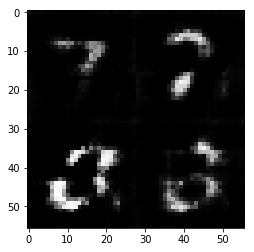

Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 1.3939
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 4.4265
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 4.0686
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 5.5619
Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 2.4146
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.8207


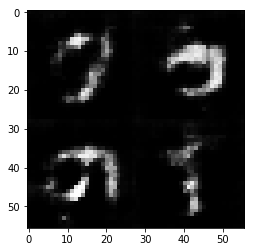

Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 1.8007
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 2.7858
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.2467
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 2.2927
Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 2.1560
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 2.8784
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 1.0492


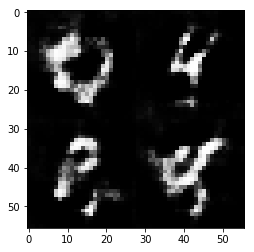

Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 2.1711
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 2.2423
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 2.5680
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 2.2011


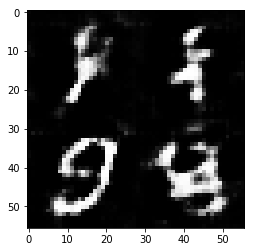

Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 2.1718
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.9368
Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 0.3678
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.7303
Epoch 2/2... Discriminator Loss: 0.9005... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 0.5771... Generator Loss: 1.8033


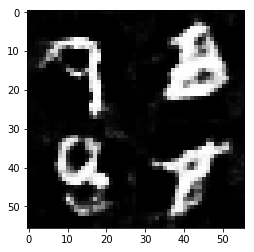

Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 1.5768
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 2.5388
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 2.5069
Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 2.5864
Epoch 2/2... Discriminator Loss: 0.6581... Generator Loss: 1.8193
Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 3.9957
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 2.6935
Epoch 2/2... Discriminator Loss: 0.5976... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 0.8458


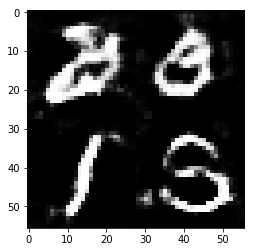

Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.5487
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 1.6539
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.4112
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 2.0773
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.1827
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 2.3670
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 0.8947


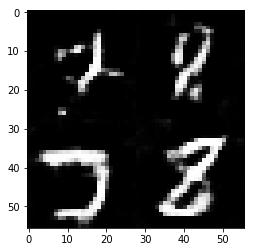

Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 1.3080
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.5797


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.3031... Generator Loss: 0.0575
Epoch 1/1... Discriminator Loss: 2.3140... Generator Loss: 1.7612
Epoch 1/1... Discriminator Loss: 1.9239... Generator Loss: 1.9230
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.6544


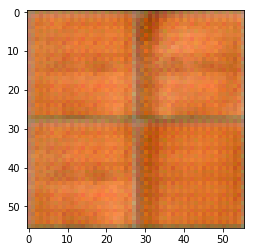

Epoch 1/1... Discriminator Loss: 1.9149... Generator Loss: 0.2126
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.2532
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8071


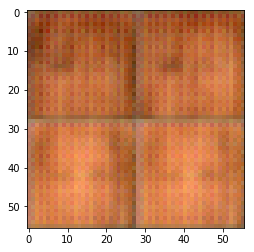

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.6875... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6480


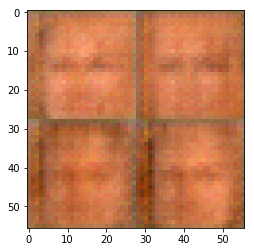

Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7829


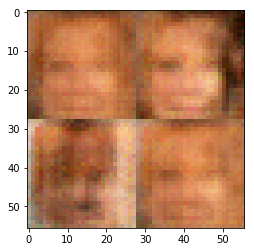

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 1.1275


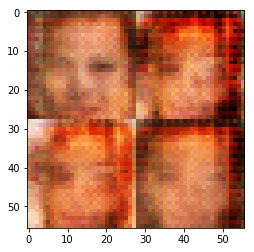

Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7923


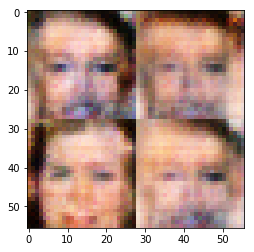

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7653


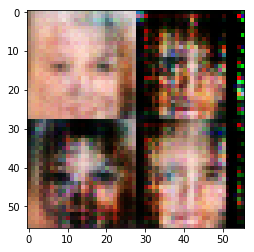

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6902


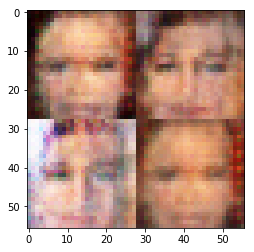

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8525


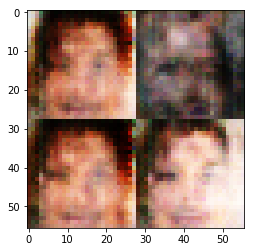

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.4158
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.7420


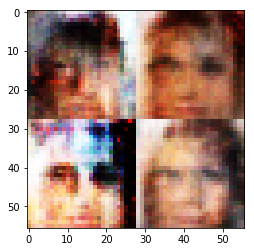

Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.8715... Generator Loss: 2.2197
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.4932


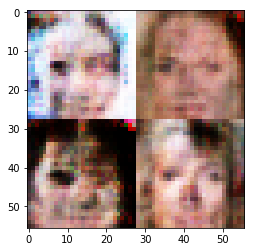

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.3241
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8268


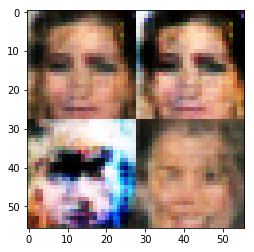

Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.9573


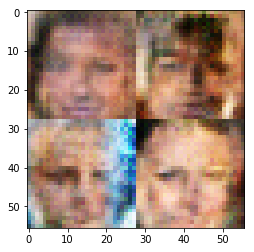

Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.5027
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 1.7844


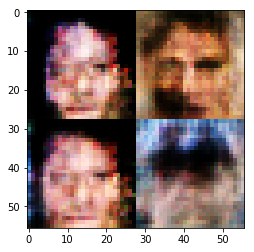

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.4698


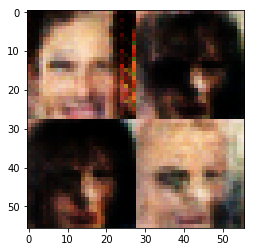

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9887


In [69]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.